loading dataset:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0  57.0  1.0   3       145   233    1        0      150      0      2.3   
1  64.0  0.0   2       130   250    0        1      187      0      3.5   
2  52.0  1.0   1       130   204    0        0      172      0      1.4   
3  56.0  0.0   1       120   236    0        1      178      0      0.8   
4  66.0  0.0   0       120   354    0        1      163      1      0.6   

   slope  ca  thal  target  
0      0   0     1       1  
1      0   0     2       1  
2      2   0     2       1  
3      2   0     2       1  
4      2   0     2       1  
checking data info and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26083 entries, 0 to 26082
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       26083 non-null  float64
 1   sex       26058 non-null  float64
 2   cp        26083 non-null  int64  
 3   trestbps  

<ipython-input-1-34eafb767407>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sex'].fillna(df['sex'].mode()[0], inplace=True)


risk_score
1    12146
0    10389
2     3458
3       90
Name: count, dtype: int64
removing outliers from key numerical features:
average cholesterol by heart disease:
target
0    247.367208
1    237.990118
Name: chol, dtype: float64
average blood pressure by heart disease:
target
0    132.047364
1    128.258247
Name: trestbps, dtype: float64
correlation between cholesterol and blood pressure:
              chol  trestbps
chol      1.000000  0.098517
trestbps  0.098517  1.000000
correlation between age and heart rate:
              age   thalach
age      1.000000 -0.053635
thalach -0.053635  1.000000
average risk score by age group:
age_group
30-44       0.673540
45-59       0.703277
60-74       0.712334
75+         0.726628
Under 30    0.614496
Name: risk_score, dtype: float64

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2215
           1       1.00  

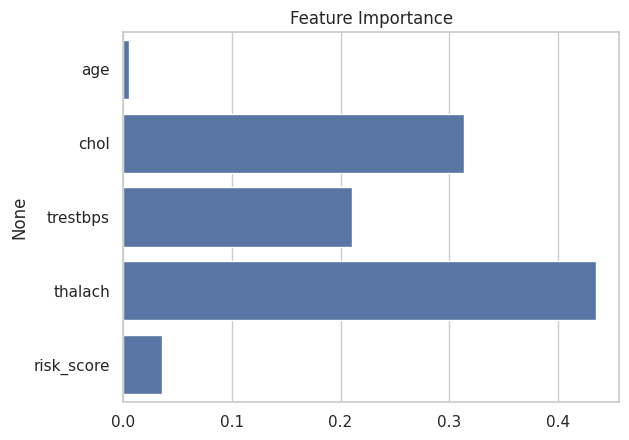

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set(style="whitegrid")

print("=" * 100)
print("loading dataset:")
df = pd.read_csv('/content/hypertension_data.csv')
print(df.head())

print("=" * 100)
print("checking data info and missing values:")
print(df.info())
print(df.isnull().sum())

print(df.dtypes)


print("=" * 100)
print("checking duplicates:")
print("Duplicates found:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

print("=" * 100)
print("filling missing values in 'sex':")
df['sex'].fillna(df['sex'].mode()[0], inplace=True)

print("=" * 100)
print("creating 'age_group' column:")
def age_group(age):
    if age < 30:
        return 'Under 30'
    elif age < 45:
        return '30-44'
    elif age < 60:
        return '45-59'
    elif age < 75:
        return '60-74'
    else:
        return '75+'

df['age_group'] = df['age'].apply(age_group)
print(df['age_group'].value_counts())

print("=" * 100)
print("creating 'risk_score' column:")
df['risk_score'] = (
    (df['chol'] > 240).astype(int) +
    (df['trestbps'] > 140).astype(int) +
    (df['thalach'] < 100).astype(int)
)>
print(df['risk_score'].value_counts())

print("=" * 100)
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

print("=" * 100)
print("removing outliers from key numerical features:")
df = remove_outliers_iqr(df, 'chol')
df = remove_outliers_iqr(df, 'trestbps')
df = remove_outliers_iqr(df, 'thalach')



print("=" * 100)
print("average cholesterol by heart disease:")
print(df.groupby('target')['chol'].mean())

print("=" * 100)
print("average blood pressure by heart disease:")
print(df.groupby('target')['trestbps'].mean())

print("=" * 100)
print("correlation between cholesterol and blood pressure:")
print(df[['chol', 'trestbps']].corr())

print("=" * 100)
print("correlation between age and heart rate:")
print(df[['age', 'thalach']].corr())

print("=" * 100)
print("average risk score by age group:")
print(df.groupby('age_group')['risk_score'].mean())




#metrics

X = df[['age', 'chol', 'trestbps', 'thalach', 'risk_score']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


# 

gender distribution:


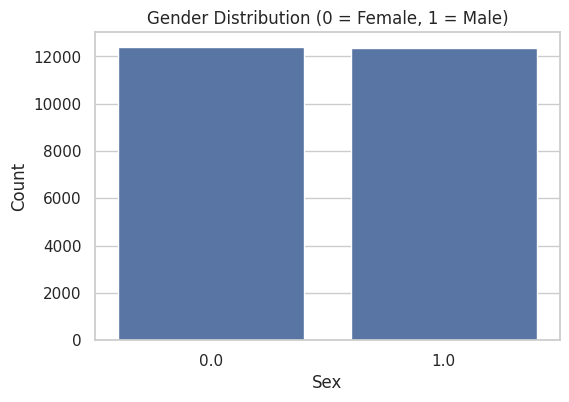

heart disease distribution (target):


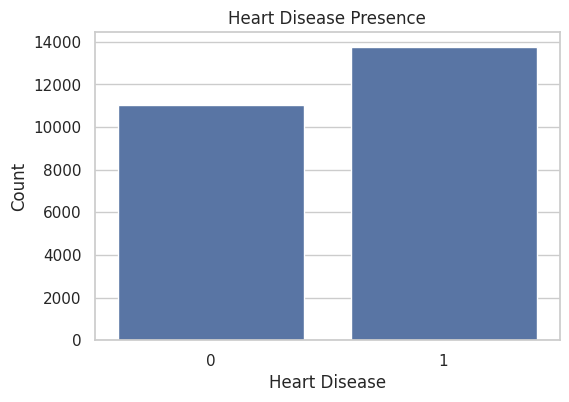

age by heart disease status:


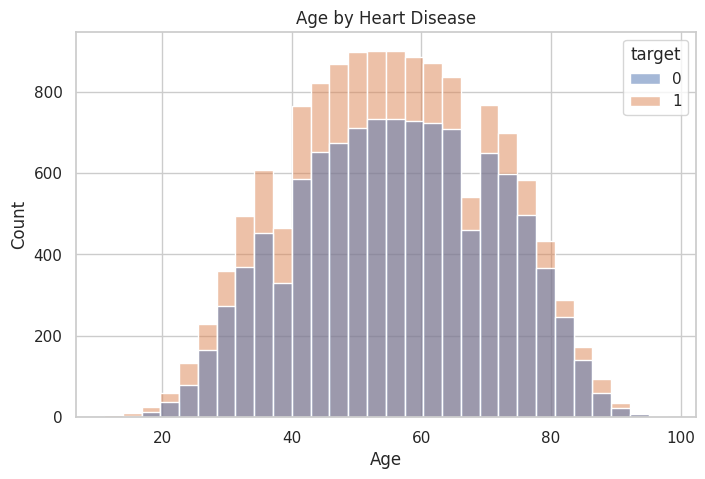

cholesterol by heart disease status:


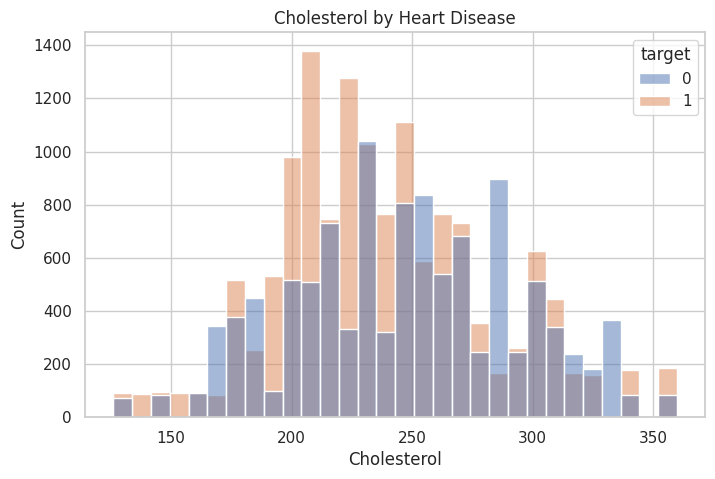

blood pressure distribution:


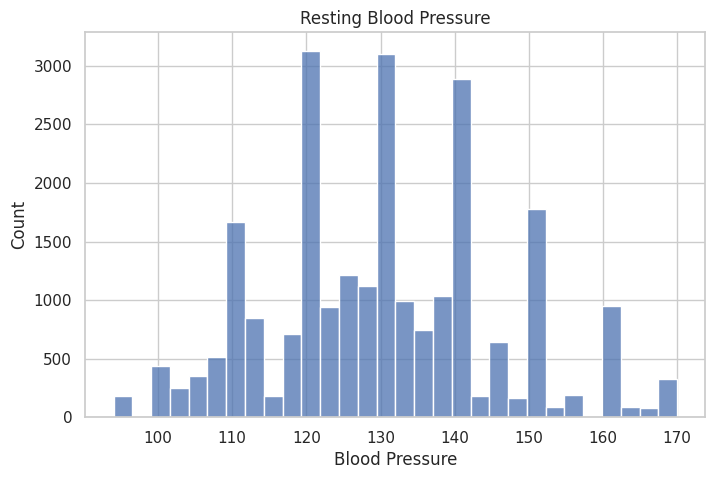

peak heart rate distribution:


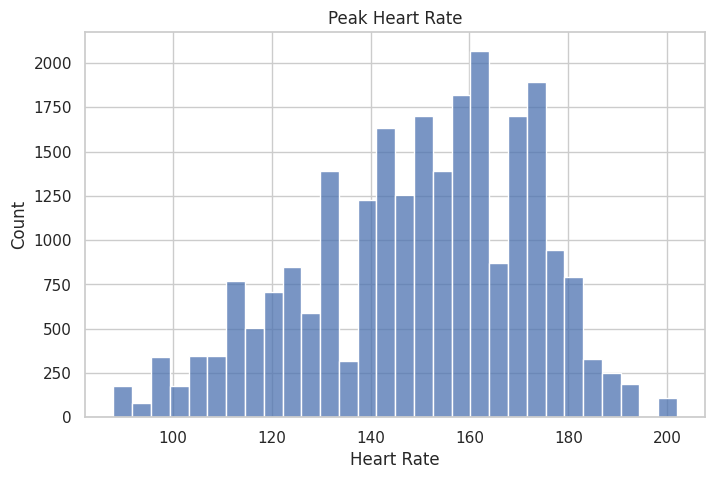

risk score distribution:


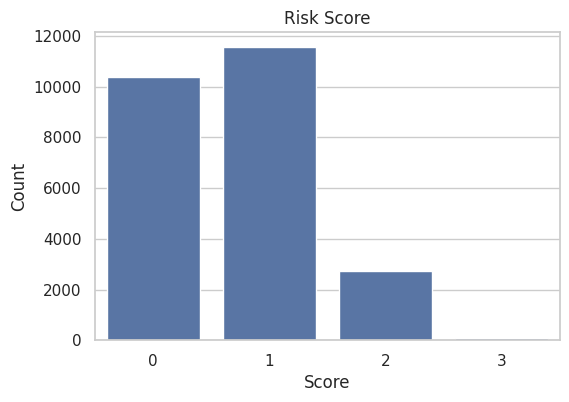

age group distribution:


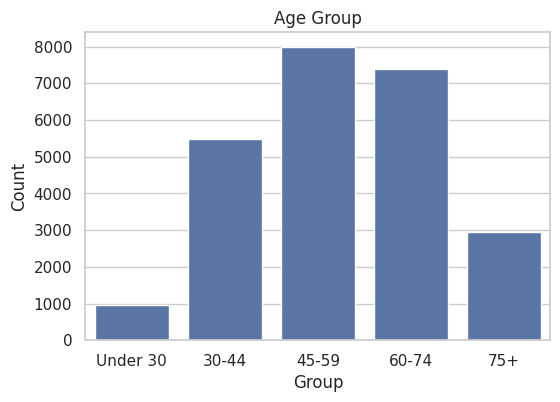

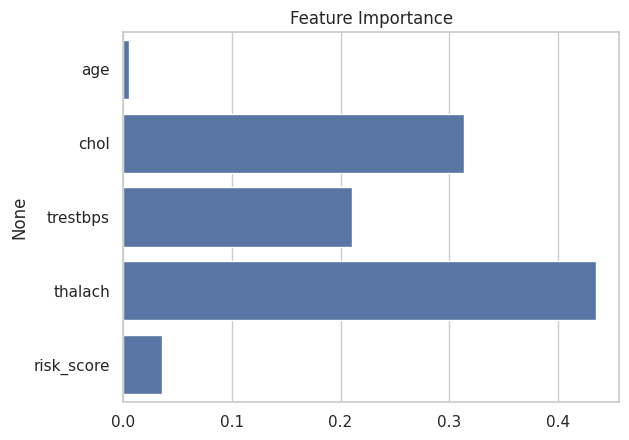

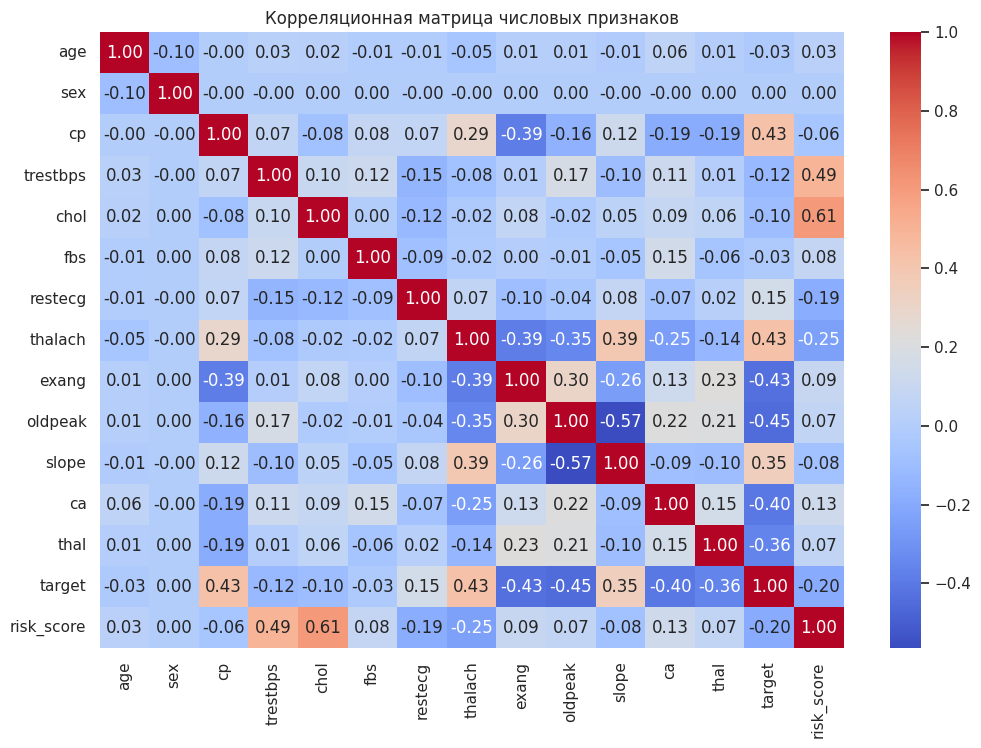

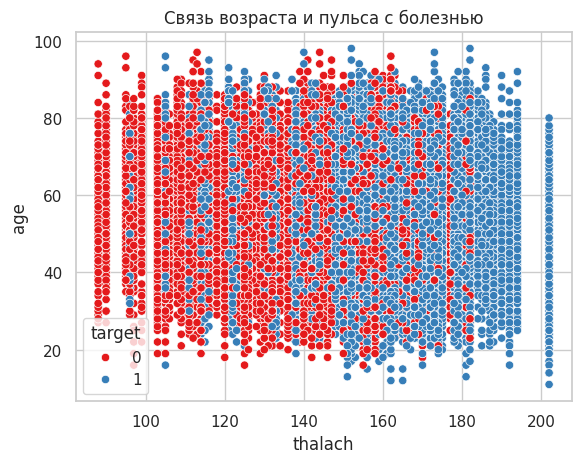

In [ ]:
print("=" * 100)
print("gender distribution:")
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', data=df)
plt.title('Gender Distribution (0 = Female, 1 = Male)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

print("=" * 100)
print("heart disease distribution (target):")
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Heart Disease Presence')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.show()

print("=" * 100)
print("age by heart disease status:")
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='age', hue='target', bins=30)
plt.title('Age by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

print("=" * 100)
print("cholesterol by heart disease status:")
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='chol', hue='target', bins=30)
plt.title('Cholesterol by Heart Disease')
plt.xlabel('Cholesterol')
plt.ylabel('Count')
plt.show()

print("=" * 100)
print("blood pressure distribution:")
plt.figure(figsize=(8, 5))
sns.histplot(df['trestbps'], bins=30)
plt.title('Resting Blood Pressure')
plt.xlabel('Blood Pressure')
plt.ylabel('Count')
plt.show()

print("=" * 100)
print("peak heart rate distribution:")
plt.figure(figsize=(8, 5))
sns.histplot(df['thalach'], bins=30)
plt.title('Peak Heart Rate')
plt.xlabel('Heart Rate')
plt.ylabel('Count')
plt.show()

print("=" * 100)
print("risk score distribution:")
plt.figure(figsize=(6, 4))
sns.countplot(x='risk_score', data=df)
plt.title('Risk Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

print("=" * 100)
print("age group distribution:")
plt.figure(figsize=(6, 4))
sns.countplot(x='age_group', data=df, order=['Under 30', '30-44', '45-59', '60-74', '75+'])
plt.title('Age Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.show()


numeric_df = df.select_dtypes(include='number')


plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix of numerical features")
plt.show()

sns.scatterplot(data=df, x="thalach", y="age", hue="target", palette="Set1")
plt.title("The relationship of age and pulse with the disease")
plt.show()

importances = model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()
